In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/MyDrive"


Mounted at /content/drive
 aptos2019-blindness-detection	     'Google AI Studio'
 aptos2019-blindness-detection.zip   'Google Keep Document.gdoc'
 aptos2019_dr_model.keras	     'homework (1).pdf'
'Blank Quiz.gform'		     'homework (2).pdf'
'Blank Quiz (Responses) (1).gsheet'  'homework (3).pdf'
'Blank Quiz (Responses).gsheet'       homework.pdf
 Classroom			      IMG-20220701-WA0021.jpg
'Colab Notebooks'		      payment.jpg
'Contact Information.gform'	      Professors.gsite
 COOK.gsite			     'Scan document2025-01-29 10-40-30.pdf'
 dr_best.h5			     'Screenshot 2025-06-30 190805.png'
 Event.gsite			     'SHANJAY (1).K.png'
'Family Update.gsite'		      SHANJAY.K.png


In [ ]:
!unzip -q "/content/drive/MyDrive/aptos2019-blindness-detection.zip" -d "/content/drive/MyDrive/aptos2019-blindness-detection"


In [ ]:
!ls "/content/drive/MyDrive/aptos2019-blindness-detection"


sample_submission.csv  test.csv  test_images  train.csv  train_images


In [ ]:
!pip install opencv-python albumentations


In [ ]:
import os, sys, random, math
import numpy as np, pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

DATASET_PATH = "/content/drive/MyDrive/aptos2019-blindness-detection"
CSV_FILE = os.path.join(DATASET_PATH, "train.csv")
IMG_DIR = os.path.join(DATASET_PATH, "train_images")
CSV_ID_COL = "id_code"
CSV_LABEL_COL = "diagnosis"

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 12
NUM_CLASSES = 5
RANDOM_SEED = 42


CSV head:


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0



Class counts:


,count
diagnosis,
0,1805
1,370
2,999
3,193
4,295


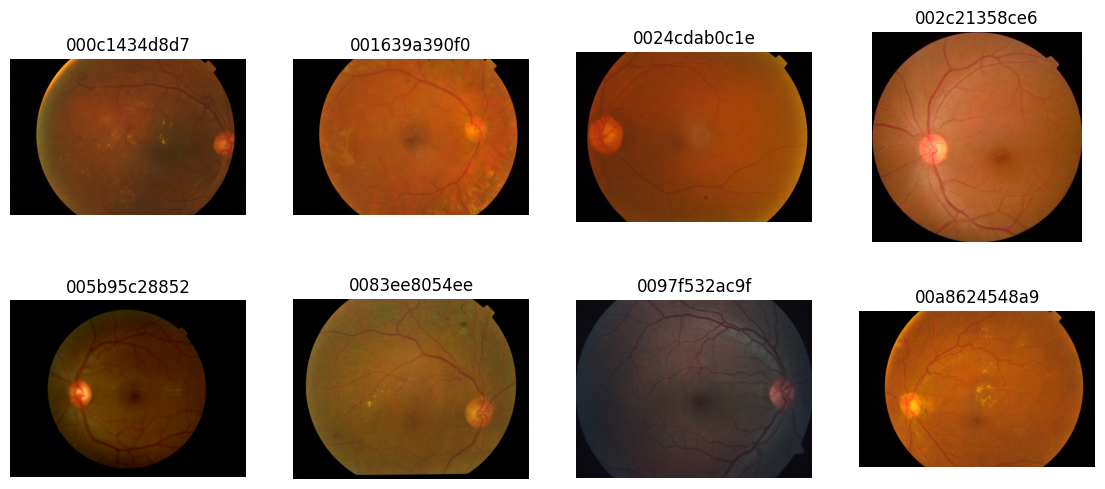

In [ ]:
df = pd.read_csv(CSV_FILE)
print("CSV head:")
display(df.head())

print("\nClass counts:")
display(df[CSV_LABEL_COL].value_counts().sort_index())

def find_image_path(img_dir, img_id):
    for ext in [".png", ".jpg", ".jpeg"]:
        p = os.path.join(img_dir, str(img_id) + ext)
        if os.path.exists(p):
            return p
    for ext in [".PNG", ".JPG", ".JPEG"]:
        p = os.path.join(img_dir, str(img_id) + ext)
        if os.path.exists(p):
            return p
    return None

sample_ids = df[CSV_ID_COL].values[:8]
plt.figure(figsize=(14,6))
for i, img_id in enumerate(sample_ids):
    p = find_image_path(IMG_DIR, img_id)
    if p is None:
        continue
    img = cv2.cvtColor(cv2.imread(p), cv2.COLOR_BGR2RGB)
    plt.subplot(2,4,i+1)
    plt.imshow(img); plt.title(str(img_id)); plt.axis("off")
plt.show()


In [ ]:
def crop_resize(img, size=IMG_SIZE):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, th = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    x,y,w,h = cv2.boundingRect(th)
    crop = img[y:y+h, x:x+w]
    if crop.size == 0:
        h0, w0 = img.shape[:2]
        minside = min(h0,w0)
        cy, cx = h0//2, w0//2
        crop = img[cy-minside//2:cy+minside//2, cx-minside//2:cx+minside//2]
    resized = cv2.resize(crop, (size, size), interpolation=cv2.INTER_AREA)
    return resized

def apply_clahe_rgb(img_rgb):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2,a,b))
    rgb2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2RGB)
    return rgb2

def preprocess_path_to_float(path, size=IMG_SIZE, clahe=False):
    path = path.decode("utf-8") if isinstance(path, bytes) else str(path)
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise FileNotFoundError(path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img = crop_resize(img, size=size)
    if clahe:
        img = apply_clahe_rgb(img)
    img = img.astype(np.float32) / 255.0
    return img


In [ ]:
ids = df[CSV_ID_COL].astype(str).values
labels = df[CSV_LABEL_COL].values.astype(int)

paths = []
lbls = []
for img_id, lab in zip(ids, labels):
    p = find_image_path(IMG_DIR, img_id)
    if p is not None:
        paths.append(p)
        lbls.append(lab)
    else:
        pass

print("Found images:", len(paths))

train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, lbls, test_size=0.2, random_state=RANDOM_SEED, stratify=lbls
)

train_paths_np = np.array(train_paths, dtype=str)
train_labels_np = np.array(train_labels, dtype=np.int32)
val_paths_np = np.array(val_paths, dtype=str)
val_labels_np = np.array(val_labels, dtype=np.int32)

def tf_load_image(path, label, clahe=False):
    img = tf.numpy_function(func=lambda p: preprocess_path_to_float(p, IMG_SIZE, clahe),
                            inp=[path], Tout=tf.float32)
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    label_onehot = tf.one_hot(label, NUM_CLASSES)
    return img, label_onehot

def make_dataset(paths_arr, labels_arr, batch_size=BATCH_SIZE, shuffle=True, augment=False, clahe=False):
    ds = tf.data.Dataset.from_tensor_slices((paths_arr, labels_arr))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths_arr), seed=RANDOM_SEED)
    ds = ds.map(lambda p, l: tf_load_image(p, l, clahe), num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        def _augment(x, y):

            x = tf.image.random_flip_left_right(x)
            x = tf.image.random_flip_up_down(x)
            x = tf.image.random_brightness(x, max_delta=0.08)
            x = tf.image.random_contrast(x, 0.9, 1.1)

            angle = tf.random.uniform([], -0.08, 0.08)
            x = tfa.image.rotate(x, angle) if 'tfa' in globals() else x
            return x, y
        ds = ds.map(_augment, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

try:
    import tensorflow_addons as tfa
except Exception:
    pass

train_ds = make_dataset(train_paths_np, train_labels_np, augment=True, clahe=True)
val_ds = make_dataset(val_paths_np, val_labels_np, augment=False, clahe=True)


Found images: 3662


In [ ]:
unique_classes = np.unique(train_labels_np)
class_w = compute_class_weight("balanced", classes=unique_classes, y=train_labels_np)
class_weight = {int(c): float(w) for c, w in zip(unique_classes, class_w)}
print("Class weights:", class_weight)


Class weights: {0: 0.4056786703601108, 1: 1.979054054054054, 2: 0.7331664580725907, 3: 3.803896103896104, 4: 2.4822033898305085}


In [ ]:
base = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",
                                            input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling="avg")
base.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Lambda(lambda x: x * 255.0)(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base(x, training=False)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
ckpt_path = "/content/drive/MyDrive/dr_best.h5"
cb = [
    callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss"),
    callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=cb
)


Epoch 1/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4858 - loss: 1.4548

184/184 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.4862 - loss: 1.4540 - val_accuracy: 0.6576 - val_loss: 0.8223 - learning_rate: 0.0010
Epoch 2/12
183/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6486 - loss: 1.0718

184/184 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.6487 - loss: 1.0717 - val_accuracy: 0.6903 - val_loss: 0.7130 - learning_rate: 0.0010
Epoch 3/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.6793 - loss: 0.9683 - val_accuracy: 0.7067 - val_loss: 0.7396 - learning_rate: 0.0010
Epoch 4/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.6853 - loss: 0.9612 - val_accuracy: 0.6357 - val_loss: 0.8371 - learning_rate: 0.0010
Epoch 5/12
183/184 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.7119 - loss: 0.9300

184/184 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.7119 - loss: 0.9298 - val_accuracy: 0.7367 - val_loss: 0.6790 - learning_rate: 5.0000e-04
Epoch 6/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.7162 - loss: 0.8919 - val_accuracy: 0.7053 - val_loss: 0.6980 - learning_rate: 5.0000e-04
Epoch 7/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.7316 - loss: 0.8742 - val_accuracy: 0.6944 - val_loss: 0.7231 - learning_rate: 5.0000e-04
Epoch 8/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7190 - loss: 0.8549

184/184 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - accuracy: 0.7191 - loss: 0.8549 - val_accuracy: 0.7217 - val_loss: 0.6763 - learning_rate: 2.5000e-04
Epoch 9/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7445 - loss: 0.8768

184/184 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.7445 - loss: 0.8766 - val_accuracy: 0.7394 - val_loss: 0.6533 - learning_rate: 2.5000e-04
Epoch 10/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.7433 - loss: 0.8115 - val_accuracy: 0.7231 - val_loss: 0.6889 - learning_rate: 2.5000e-04
Epoch 11/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.7538 - loss: 0.8069 - val_accuracy: 0.7258 - val_loss: 0.6612 - learning_rate: 2.5000e-04
Epoch 12/12
184/184 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.7400 - loss: 0.8444 - val_accuracy: 0.7299 - val_loss: 0.6787 - learning_rate: 1.2500e-04


In [ ]:

val_images_ds = val_ds.map(lambda x, y: x)

pred_probs = model.predict(val_images_ds, verbose=1)
preds = np.argmax(pred_probs, axis=1)
y_true = val_labels_np

print("Confusion matrix:")
print(confusion_matrix(y_true, preds))

print("\nClassification report:")
print(classification_report(y_true, preds))

print("Cohen's kappa:", cohen_kappa_score(y_true, preds))


46/46 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step
Confusion matrix:
[[178  55  68  38  22]
 [ 38  10  12   9   5]
 [100  25  45  19  11]
 [ 20   3  10   4   2]
 [ 24   7  17   8   3]]

Classification report:
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       361
           1       0.10      0.14      0.11        74
           2       0.30      0.23      0.26       200
           3       0.05      0.10      0.07        39
           4       0.07      0.05      0.06        59

    accuracy                           0.33       733
   macro avg       0.20      0.20      0.20       733
weighted avg       0.34      0.33      0.33       733

Cohen's kappa: 0.007091633466135505


In [ ]:
def predict_one_image(img_path, model):
    img = preprocess_path_to_float(img_path, size=IMG_SIZE, clahe=True)
    x = np.expand_dims(img, axis=0)
    probs = model.predict(x)[0]
    pred_class = int(np.argmax(probs))
    return pred_class, probs

example_path = val_paths[0]
pred_label, probs = predict_one_image(example_path, model)
print("True label:", val_labels[0], "Predicted:", pred_label, "Probs:", probs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
True label: 0 Predicted: 0 Probs: [9.9290776e-01 4.9229525e-03 1.6994709e-03 6.2216699e-05 4.0753803e-04]


In [ ]:

import os, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

DATASET_PATH = "/content/drive/MyDrive/aptos2019-blindness-detection"
CSV_FILE = os.path.join(DATASET_PATH, "train.csv")
IMG_DIR = os.path.join(DATASET_PATH, "train_images")

df = pd.read_csv(CSV_FILE)
df["id_code"] = df["id_code"].astype(str) + ".png"

print("Dataset samples:", df.shape[0])
print(df.head())

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
RANDOM_SEED = 42
NUM_CLASSES = 5
CSV_ID_COL = "id_code"
CSV_LABEL_COL = "diagnosis"

train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df[CSV_LABEL_COL], random_state=RANDOM_SEED
)

train_df[CSV_LABEL_COL] = train_df[CSV_LABEL_COL].astype(str)
val_df[CSV_LABEL_COL] = val_df[CSV_LABEL_COL].astype(str)

print("Train samples:", train_df.shape[0])
print("Validation samples:", val_df.shape[0])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col=CSV_ID_COL,
    y_col=CSV_LABEL_COL,
    directory=IMG_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col=CSV_ID_COL,
    y_col=CSV_LABEL_COL,
    directory=IMG_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

val_gen.reset()
y_true = val_df[CSV_LABEL_COL].astype(int).values
y_pred = np.argmax(model.predict(val_gen), axis=1)

print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nCohen’s Kappa:", cohen_kappa_score(y_true, y_pred))

model.save("/content/drive/MyDrive/aptos2019_dr_model.keras")
print(" Model saved successfully!")


Dataset samples: 3662
            id_code  diagnosis
0  000c1434d8d7.png          2
1  001639a390f0.png          4
2  0024cdab0c1e.png          1
3  002c21358ce6.png          0
4  005b95c28852.png          0
Train samples: 2929
Validation samples: 733
Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 1657s 18s/step - accuracy: 0.4363 - loss: 1.3785 - val_accuracy: 0.4925 - val_loss: 1.3082 - learning_rate: 0.0010
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 766s 8s/step - accuracy: 0.4868 - loss: 1.3203 - val_accuracy: 0.4925 - val_loss: 1.3061 - learning_rate: 0.0010
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 749s 8s/step - accuracy: 0.4928 - loss: 1.3249 - val_accuracy: 0.4925 - val_loss: 1.3400 - learning_rate: 0.0010
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 737s 8s/step - accuracy: 0.4647 - loss: 1.3299 - val_accuracy: 0.4925 - val_loss: 1.3001 - learning_rate: 0.0010
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 711s 8s/step - accuracy: 0.4709 - loss: 1.3492 - val_accuracy: 0.4925 - val_loss: 1.3057 - learning_rate: 0.0010
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 709s 8s/step - accuracy: 0.4684 - loss: 1.3076 - val_accuracy: 0.4925 - val_loss: 1.3002 - learning_rate: 0.0010
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 721s 8s/step - accuracy: 0.4975 - loss: 1.3002 - val_a

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Model saved successfully!


In [ ]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_df["diagnosis"].astype(int)),
    y=train_df["diagnosis"].astype(int)
)
class_weights = dict(enumerate(class_weights))
print(class_weights)


{0: np.float64(0.4056786703601108), 1: np.float64(1.979054054054054), 2: np.float64(0.7331664580725907), 3: np.float64(3.803896103896104), 4: np.float64(2.4822033898305085)}
